In [1]:
import os
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import seaborn as sns

Enter 1 to train the model or 0 to use the pre-trained model:1
Enter the number of episodes to train the model for:1500
Enter the target average reward that you want to achieve with th network:200
Enter 1 if you want to see network training results, else 0:1
Enter the learning rate to train the model:0.001
The average rewards till episode 1 is 12.0
The average rewards till episode 51 is 37.66
The average rewards till episode 101 is 67.62
The average rewards till episode 151 is 94.22
The average rewards till episode 201 is 114.32
The average rewards till episode 251 is 174.86
The average rewards till episode 301 is 181.82
The average rewards till episode 351 is 188.0
The average rewards till episode 401 is 188.92
The average rewards till episode 451 is 93.94
The average rewards till episode 501 is 193.76
The average rewards till episode 551 is 195.6
The average rewards till episode 601 is 196.48
The average rewards till episode 651 is 111.56
The average rewards till episode 701 is 108.0

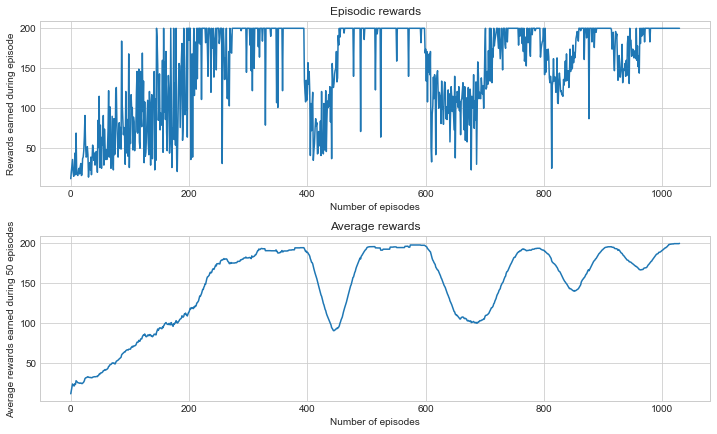

In [2]:
class CART_POLE_TRAINER(nn.Module):

    def __init__(self, episodes, target_avg_reward, verbose = True, learning_rate = 0.001):
        super(CART_POLE_TRAINER, self).__init__()
        self.episodes = episodes
        self.target_avg_reward = target_avg_reward
        self.verbose = verbose
        self.learning_rate = learning_rate
        self.num_actions = env.action_space.n
        self.state_dim = env.observation_space.shape[0]
        self.fc1 = nn.Linear(self.state_dim, 300)
        self.fc2 = nn.Linear(300, self.num_actions)
        self.optimizer = optim.Adam(self.parameters(), lr = self.learning_rate)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def update_weights(self, loss):

        # Initializing all the gradients to zero
        self.optimizer.zero_grad()

        # Back-propagating the loss and updating the weights
        loss.backward()
        self.optimizer.step()

    def update_network_parameters(self, rewards, log_probs, discount_factor = 0.99):

        loss = []
        discounted_rewards = [i for i in rewards]
        for i in range(len(discounted_rewards) - 2, -1, -1):
            discounted_rewards[i] = discounted_rewards[i] + discount_factor * discounted_rewards[i + 1]

        # Generating tensor for the discounted rewards
        discounted_rewards = torch.tensor(discounted_rewards)

        # Calculating the loss per time step in an episode
        for log_prob, reward in zip(log_probs, discounted_rewards):
            loss.append(-log_prob * reward)

        # Calculating the total loss
        loss = torch.cat(loss).sum()

        # Updating the weights
        self.update_weights(loss)

    def action_probabilities(self, state):

        state = Variable(torch.from_numpy(state)).type(torch.FloatTensor).unsqueeze(0)
        policy_values = policy(state)
        action_probabilities = F.softmax(policy_values, dim=-1)
        return action_probabilities

    def generate_episode(self, t_max=1500):

        states = [] ; actions = []
        rewards = [] ; log_probs = []

        # Creating the new state
        new_state = env.reset()

        # Iterating for the number of time steps or till the game terminates, whichever is minimum
        for t in range(t_max):
            action_probs = self.action_probabilities(new_state)
            sampler = Categorical(action_probs)
            action_sampled = sampler.sample()
            log_prob = sampler.log_prob(action_sampled)
            state, reward, done, info = env.step(action_sampled.item())
            rewards.append(reward)
            log_probs.append(log_prob)
            new_state = state
            if done:
                break
        self.update_network_parameters(rewards, log_probs)

        # Returning the total rewards achieved in an episode
        return sum(rewards)

    def plot_rewards(self, rewards, average_rewards):

        # Setting the palette style for the plot
        plt.style.use('seaborn-whitegrid')

        # Creating figure object for holding the sub-plots
        fig = plt.figure(figsize=(12, 7))
        ax1 = fig.add_subplot(2, 1, 1)
        ax2 = fig.add_subplot(2, 1, 2)
        plt.subplots_adjust(hspace=.3)

        # Creating the plot to show rewards earned in an episode
        ax1.set_title('Episodic rewards')
        ax1.plot(rewards)
        ax1.set_xlabel("Number of episodes")
        ax1.set_ylabel("Rewards earned during episode")

        # Creating the plot to show average rewards earned over 50 episodes
        ax2.set_title('Average rewards')
        ax2.plot(average_rewards)
        ax2.set_xlabel("Number of episodes")
        ax2.set_ylabel("Average rewards earned during 50 episodes")

        plt.show()

    def play_game(self, num_episodes=10, render=False):

        # Generating rewards for given number of episodes
        for i in range(num_episodes):
            rewards = []
            new_state = env.reset()

            # Iterating for the number of time steps or till the game terminates, whichever is minimum
            for t in range(1500):
                # Creating the scene if user wants to see the video
                if(render):
                    env.render()
                action_probs = self.action_probabilities(new_state)
                sampler = Categorical(action_probs)
                action_sampled = sampler.sample()
                state, reward, done, info = env.step(action_sampled.item())
                rewards.append(reward)
                new_state = state
                if done:
                    print("Rewards earned in episode {} is {}".format(i + 1, np.sum(rewards)))
                    break

    def train_network(self):
        # Initializing the list of rewards for each episode and for average number of rewards
        rewards = []
        average_rewards = []

        # Generate training data by generating episodes and update the action deciding policy
        for i in range(self.episodes):
            reward = self.generate_episode()
            rewards.append(reward)
            average_reward = np.mean(rewards[-50:])
            average_rewards.append(average_reward)

            if self.verbose:
                if not i % 50:
                    print("The average rewards till episode {} is {}".format(i + 1, average_reward))

            if i >= 50 and average_reward >= self.target_avg_reward:
                print("The average rewards till episode {} is {}".format(i + 1, average_reward))
                print("The game ran for a total of {}  episodes and was solved after {} episodes.".format(i + 1, i - 50 + 1))
                break
            elif i == (self.episodes) - 1:
                print("The game could not be solved in {} episodes. Please try increasing the number of episodes.".format(self.episodes))

        # Plotting the rewards in each episode and the average number of rewards over 100 episodes
        self.plot_rewards(rewards, average_rewards)

        # Saving the model for future use
        torch.save(policy, "training_policy.pt")


if __name__ == "__main__":

    # Creating the environment
    env = gym.make("CartPole-v0")
    env.reset()

    # Creating choice for the user to train the model from scratch or use the pre-trained model
    choice = int(input('Enter 1 to train the model or 0 to use the pre-trained model:'))
    if(choice):
        num_episodes = int(input('Enter the number of episodes to train the model for:'))
        target_avg_reward = int(input('Enter the target average reward that you want to achieve with th network:'))
        verbose = input('Enter 1 if you want to see network training results, else 0:')
        learning_rate = float(input('Enter the learning rate to train the model:'))
        policy = CART_POLE_TRAINER(num_episodes, target_avg_reward, verbose, learning_rate)
        policy.train_network()
    else:
        if(os.path.isfile('training_policy.pt')):
            policy = torch.load('training_policy.pt')
            num_episodes = int(input('Enter the number of episodes for which you want to play the game:'))
            render = int(input('Enter 1 if you want to watch the game, else 0:'))
            policy.play_game(num_episodes, render)

        else:
            print('The model does not exist. Please train the model first and try again!')
            exit()
